<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# MNIST

This chapter is concerned with the MNIST data set which contains 70000 imags of written images. First we used sklearn to open them. We use a function created by the author of the book to sort the data accordingly.

In [3]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist) # fetch_openml() returns an unsorted dataset

In [4]:
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

Data sets loaded with Sckit-Learn have a dictionary format as follows

**DESCR** key that describes the data set <br>
**Data** key containing an array with one row per instance and one column per feature <br>
**Target** key containing an array with labels.

In [5]:
X, y = mnist["data"], mnist["target"]

In [6]:
X.shape

(70000, 784)

(70000 images with 784 pixels each)

In [7]:
y.shape

(70000,)

In this case, our data set has 70000 images with 784 features per image (28 by 28 pixels). The target array contains the labels, which in this case is the name of each symbol drawn in each picture.

Lets look at one of the images:

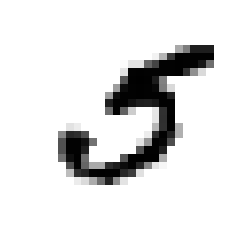

In [46]:
%matplotlib inline

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation = 'nearest')
plt.axis('off')
plt.show()

This looks like a 5, and sure enough the label tells us that it is:

In [9]:
y[36000]

5

Lets create a test set and a training set from this data set.

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Now lets shuffle the data randomly.

In [11]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

For now we will look to classify one digit: the number 5. Our algorithm will thus be a binary classifier, capable of detecting either 5 or not 5.

In [12]:
y_train_5 = (y_train == 5) #boolean array
y_test_5 = (y_test == 5)

Now we need to pick a classifier and train it- a good place to start is with the *Sci-kit Gradient Descent* classifier using the class SGDClassifier. 

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

Lets see how it works on the number 5 we plotted above.

In [14]:
sgd_clf.predict([some_digit])

array([ True])

It returns that the number is indeed the number 5, so this is good.

# Performance Measures

Since evaluating a classifier is in many cases more difficult than evaluating a regressor (with a regressor you can just look at RMSE), we spend most of this chapter discussing this.

## Measuring Using Cross-Validation

Here we use three folds on the training data set to test the algorithm.

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95605, 0.9645 , 0.9609 ])

Naively we might assume that this means that the algorithm is $~95\%$ accurate. But consider this classifier below which automatically assumes that *everythin* is not a five.

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # returns array of Falses

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9124 , 0.90605, 0.9105 ])

Even though everything is being predicted as false, we're still getting around $90\%$ accuracy (this is because 5's account for about $10\%$ of the digits so we expect to be wrong approximately this often).

## Measuring using a Confusion Matrix

In a confusion matrix $\bf{M}$ the entry $M_{ij}$ tells you the number of times class $i$ was identified as class $j$. Under perfect classification the confusion matrix should be a diagonal (class $i$ is only identified as class $i$).

To compute the matrix, we need to have a set of predictions (similar to cross-validation). For this we will use the cross_val_predict() function

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

This is similar to cross_val_score(), but this time it returns an actual data set of predictions. Each data element is computed using a different fold.

In [19]:
y_train_pred

array([False, False, False, ..., False, False, False])

Now lets get the confusion matrix.

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53386,  1193],
       [ 1178,  4243]])

The first row represents "non-five" images and the second row presents "five" images. The columns are the same, but they contain the number of classifications.

For example, looking at the entry $M_{12}$ we get that 1671 "non-five images" were classified as "five images." In general, then.


<h1><center>$M_{ij}$ "class i's" are identified as "class j's"</center></h1>


Here's a perfect matrix.

In [21]:
confusion_matrix(y_train_pred, y_train_pred)

array([[54564,     0],
       [    0,  5436]])

While the confusion matrix gives a lot of information, sometimes one requires a more precise metric. The first one we consider is the accuracy of positive predictions (in this case "five images" is the *positive* class whereas "non-five-images" is the *negative* class).

$$\text{precision} = \frac{\text{TP}}{\text{TP}+\text{FP}} $$

where TP is the number of true positives (correctly identified "fives") and FP is the number of false positives (things identified as "fives" that should have been "non-fives").

This can also be combined with another metric

$$\text{recall} = \frac{\text{TP}}{\text{TP}+\text{FN}} $$

where FN is the number of false negatives (things identified as "non-fives" that should have been "fives"). To think about this in a practical way:

**Precision:** The ratio of correct positives to all things identified as positive. <br>
**Recall:** The ratio of correct positives to all things that should have been identified as positive.

In the case of detecting illness, it is better to have a higher recall than precision, since we want to treat all people who might have the illness. The low precision means that some patients might need to come in to get reaccessed.

We can also combine precision and recall into a signle metric, the F score. The F score is the harmonic mean of precision and recall, and thus is only high if *both* the precision and recall are high

$$F_1 = \frac{2}{\frac{1}{\text{precision}}+\frac{1}{\text{recall}}}=2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}} = \frac{\text{TP}}{\text{TP}+\frac{\text{FN}+\text{FP}}{2}}$$

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [33]:
precision_score(y_train_5, y_train_pred)

0.7805371596762325

In [28]:
recall_score(y_train_5, y_train_pred)

0.7826969193875669

In [32]:
f1_score(y_train_5, y_train_pred)

0.7816155475729942

## The Precision/Recall Tradeoff

The SGDClassifier makes its classification decisions by computing a threshhold based on a decision function, and if an instances score is greater than that threshhold then it is placed in the positive class, else the negative class. Thus *increasing* the threshhold increases precision but decreases recall, and *decreasing* the threshhold increases recall but decreases precision.

This can be easily imaged using a thought experiment. If the threshhold is *really high*, then both TP and FP approach zero. But in this limit, we have only the best cases (these examples would have a very high score) and so TP would be considerably larger than FP (even though both are small) and the ratio approaches 1. If the threshhold is *really low* then TP becomes really large (we account for almost all the 5's) and FN becomes really small (very few of the 5's are missed). Once again, the ratio approaches 1.

Lets look at the threshhold of a certain picture. Below we look at the threshhold of the 5 we plotted above.

In [47]:
y_score_1 = sgd_clf.decision_function([X[36000]]) #  5
y_score_2 = sgd_clf.decision_function([X[36001]]) # A poorly drawn 5
y_score_3 = sgd_clf.decision_function([X[10001]]) # The number 1
print('Score of 5 Image {}'.format(y_score_1))
print('Score of Bad-5 Image {}'.format(y_score_2))
print('Score of 1 Image {}'.format(y_score_3))

Score of 5 Image [110828.11931753]
Score of Bad-5 Image [-84281.99732738]
Score of 1 Image [-336150.109846]


Note how the badly drawn 5 gets a negative score, but the 1 (which looks quite different from a 5) gets a very negative score.

The SGDClassifier uses a threshhold of 0 for positive, so anything above 0 will be classified as a 5. Lets use cross_val_predict again and specify that we want to return decision scores instead of predictions.

In [48]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

Instead of returning True or False, it returns the scores themselves. Thus we can vary the threshhold and easily compute the precision and recall. This is shown in the plot below.

In [49]:
y_scores

array([-561268.06101349, -111530.40062712, -155746.7400119 , ...,
       -240239.08884192, -273485.72190976, -368269.32779834])

Use a special function to get precisions and recalls.

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, threshholds = precision_recall_curve(y_train_5, y_scores)

Plot.

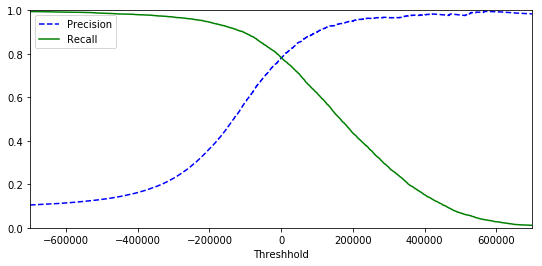

In [26]:
def plot_precision_recall_vs_threshhold(precisions, recalls, threshholds):
    plt.plot(threshholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(threshholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshhold')
    plt.ylim([0, 1])
    plt.legend()
    
fig, ax = plt.subplots(figsize=(9,4))
plot_precision_recall_vs_threshhold(precisions, recalls, threshholds)
plt.xlim([-700000, 700000])
plt.show()

As you can see, increasing precision decreases recall and vice versa. Plots like these can be used to determine an appropriate threshhold value to use for a specific task.